# Multi-task Transformer Model

This notebook trains a regression+classification transformer model using data from multiple stocks.

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from numerical_preprocessing import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

tf.random.set_seed(1234)

Check if GPU is available

In [3]:
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available: 1


In [4]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

### Import Dataset

In [5]:
data = pd.read_csv("../stock_yfinance_data.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


### Preprocess Stocks

In [6]:
feature_cols = ['percent_open', 'percent_high', 'percent_low', 'percent_close', 'volume', 
                'sma', 'ema', 'rsi', 'macd', 'bb_middle', 'bb_upper', 'bb_lower']
target_cols = ['future_magnitude', 'future_direction']
num_features = len(feature_cols)
num_targets = len(target_cols)
prev_days = 20
future_days = 1
test_size = 30 # days per stock

In [7]:
train_x = []
train_y = []
test_x = []
test_y = []

train_tickers = []
test_tickers = []
scalers = {}

train_data = pd.DataFrame({})
test_data = pd.DataFrame({})

tickers = data['Stock Name'].unique()

for ticker in tickers:

    # Filter for stock data
    stock_data = data[data['Stock Name'] == ticker]

    # Clean data
    stock_data = clean_stock_data(stock_data, ticker=None)

    # Calculate percent change between trading days
    stock_data['percent_open'], stock_data['percent_high'], stock_data['percent_low'], stock_data['percent_close'] = percent_price_change(stock_data)
    
    # Calculate technical indicators
    stock_data['sma'] = simple_moving_average(stock_data)
    stock_data['ema'] = exponential_moving_average(stock_data)
    stock_data['rsi'] = calculate_rsi(stock_data)
    stock_data['macd_line'], stock_data['macd_signal'], stock_data['macd'] = calculate_macd(stock_data)
    stock_data['bb_middle'], stock_data['bb_upper'], stock_data['bb_lower'] = bollinger_bands(stock_data)
    stock_data['future_percent'] = calculate_future_close(stock_data)
    stock_data.dropna(inplace=True)

    # Compute regression & binary classification targets before scaling
    stock_data['future_magnitude'] = stock_data['future_percent'].abs() # convert to magnitude
    stock_data['future_direction'] = (stock_data['future_percent'] > 0).astype(int)  # 1 if up, 0 if down

    # Normalize features
    scaler = MinMaxScaler()
    scale_cols = feature_cols+[target_cols[0]]
    stock_data.loc[:, scale_cols] = scaler.fit_transform(stock_data.loc[:, scale_cols])
    scalers[ticker] = scaler

    # Generate training & test feature data
    feature_array = stock_data[feature_cols].to_numpy()
    stock_x = generate_feature_data(feature_array, sequence_size=prev_days, pred_size=future_days)

    # Slice stock_data properly to match sequence data
    stock_data = stock_data.iloc[prev_days:-future_days].reset_index(drop=True)

    # Stack y1-magnitude (regression) and y2-direction (classification)
    stock_y1 = stock_data['future_magnitude'].to_numpy()
    stock_y2 = stock_data['future_direction'].to_numpy()
    train_y.append(np.column_stack((stock_y1[:-test_size], stock_y2[:-test_size])))
    test_y.append(np.column_stack((stock_y1[-test_size:], stock_y2[-test_size:])))

    # Append data
    train_x.append(stock_x[:-test_size])
    test_x.append(stock_x[-test_size:])

    # Track stock names for each entry
    train_tickers.extend([ticker] * (len(stock_x) - test_size))
    test_tickers.extend([ticker] * test_size)

    # Append clean stock data
    train_data = pd.concat([train_data, stock_data.iloc[:-test_size]], ignore_index=True)
    test_data = pd.concat([test_data, stock_data.iloc[-test_size:]], ignore_index=True)

# Convert training and testing sets to arrays
train_x = np.vstack(train_x)
train_y = np.vstack(train_y)
test_x = np.vstack(test_x)
test_y = np.vstack(test_y)

# Convert stock labels to arrays
train_tickers = np.array(train_tickers)
test_tickers = np.array(test_tickers)

In [8]:
train_x.shape

(4525, 20, 12)

In [9]:
train_y.shape

(4525, 2)

In [10]:
train_tickers.shape

(4525,)

In [11]:
scalers

{'TSLA': MinMaxScaler(),
 'MSFT': MinMaxScaler(),
 'PG': MinMaxScaler(),
 'META': MinMaxScaler(),
 'AMZN': MinMaxScaler(),
 'GOOG': MinMaxScaler(),
 'AMD': MinMaxScaler(),
 'AAPL': MinMaxScaler(),
 'NFLX': MinMaxScaler(),
 'TSM': MinMaxScaler(),
 'KO': MinMaxScaler(),
 'F': MinMaxScaler(),
 'COST': MinMaxScaler(),
 'DIS': MinMaxScaler(),
 'VZ': MinMaxScaler(),
 'CRM': MinMaxScaler(),
 'INTC': MinMaxScaler(),
 'BA': MinMaxScaler(),
 'BX': MinMaxScaler(),
 'NOC': MinMaxScaler(),
 'PYPL': MinMaxScaler(),
 'ENPH': MinMaxScaler(),
 'NIO': MinMaxScaler(),
 'ZS': MinMaxScaler(),
 'XPEV': MinMaxScaler()}

In [12]:
train_data

,date,open,high,low,close,adj_close,volume,stock_name,percent_open,percent_high,percent_low,percent_close,sma,ema,rsi,macd_line,macd_signal,macd,bb_middle,bb_upper,bb_lower,future_percent,future_magnitude,future_direction
0,2021-11-24,360.130005,377.589996,354.000000,372.000000,372.000000,0.229401,TSLA,0.313920,0.350731,0.427854,0.498239,0.996722,0.968588,0.284683,14.595007,17.303938,0.262689,0.996722,0.878327,0.975157,-3.053760,0.223228,0
1,2021-11-26,366.489990,369.593323,360.333344,360.640015,360.640015,0.000000,TSLA,0.374061,0.193530,0.481675,0.355049,0.997296,0.969512,0.261214,13.006359,16.444422,0.223167,0.997296,0.878240,0.976467,5.090023,0.374185,1
2,2021-11-29,366.996674,380.890015,366.730011,378.996674,378.996674,0.164125,TSLA,0.551208,0.546666,0.716798,0.671733,1.000000,0.983856,0.392891,13.077820,15.771102,0.263538,1.000000,0.880661,0.978689,0.683382,0.047502,1
3,2021-11-30,381.456665,389.333344,372.666656,381.586670,381.586670,0.324958,TSLA,0.490397,0.383821,0.553115,0.500374,0.992493,0.998740,0.611356,13.191382,15.255158,0.297660,0.992493,0.864661,0.985450,-4.346763,0.319084,0
4,2021-12-01,386.899994,390.946655,363.586670,365.000000,365.000000,0.234811,TSLA,0.530992,0.368343,0.404633,0.304768,0.983438,1.000000,0.464531,11.806873,14.565501,0.259995,0.983438,0.853706,0.981974,-0.949774,0.067250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520,2022-08-09,23.320000,23.709999,22.139999,22.690001,22.690001,0.157525,XPEV,0.408956,0.242441,0.473695,0.281193,0.301022,0.284688,0.215070,-1.467863,-1.212932,0.503113,0.301022,0.320883,0.257261,0.925514,0.029893,1
4521,2022-08-10,23.110001,23.110001,22.040001,22.900000,22.900000,0.147302,XPEV,0.430488,0.216461,0.504322,0.339561,0.290742,0.278103,0.223351,-1.464131,-1.263172,0.524201,0.290742,0.303252,0.256415,7.467253,0.251575,1
4522,2022-08-11,23.580000,25.910000,23.209999,24.610001,24.610001,0.404596,XPEV,0.463771,0.519657,0.619173,0.490480,0.282737,0.277029,0.558296,-1.308111,-1.272160,0.588671,0.282737,0.279388,0.267816,-0.812681,0.026069,0
4523,2022-08-12,23.670000,24.480000,23.379999,24.410000,24.410000,0.096472,XPEV,0.261734,0.152582,0.446241,0.299460,0.275060,0.275486,0.578805,-1.186920,-1.255112,0.629360,0.275060,0.253749,0.282027,-3.727980,0.124861,0


### Plot Stock Price

In [13]:
ticker = 'TSLA'
plotting_data = train_data[train_data['stock_name'] == ticker]
plotting_data.reset_index(inplace=True)

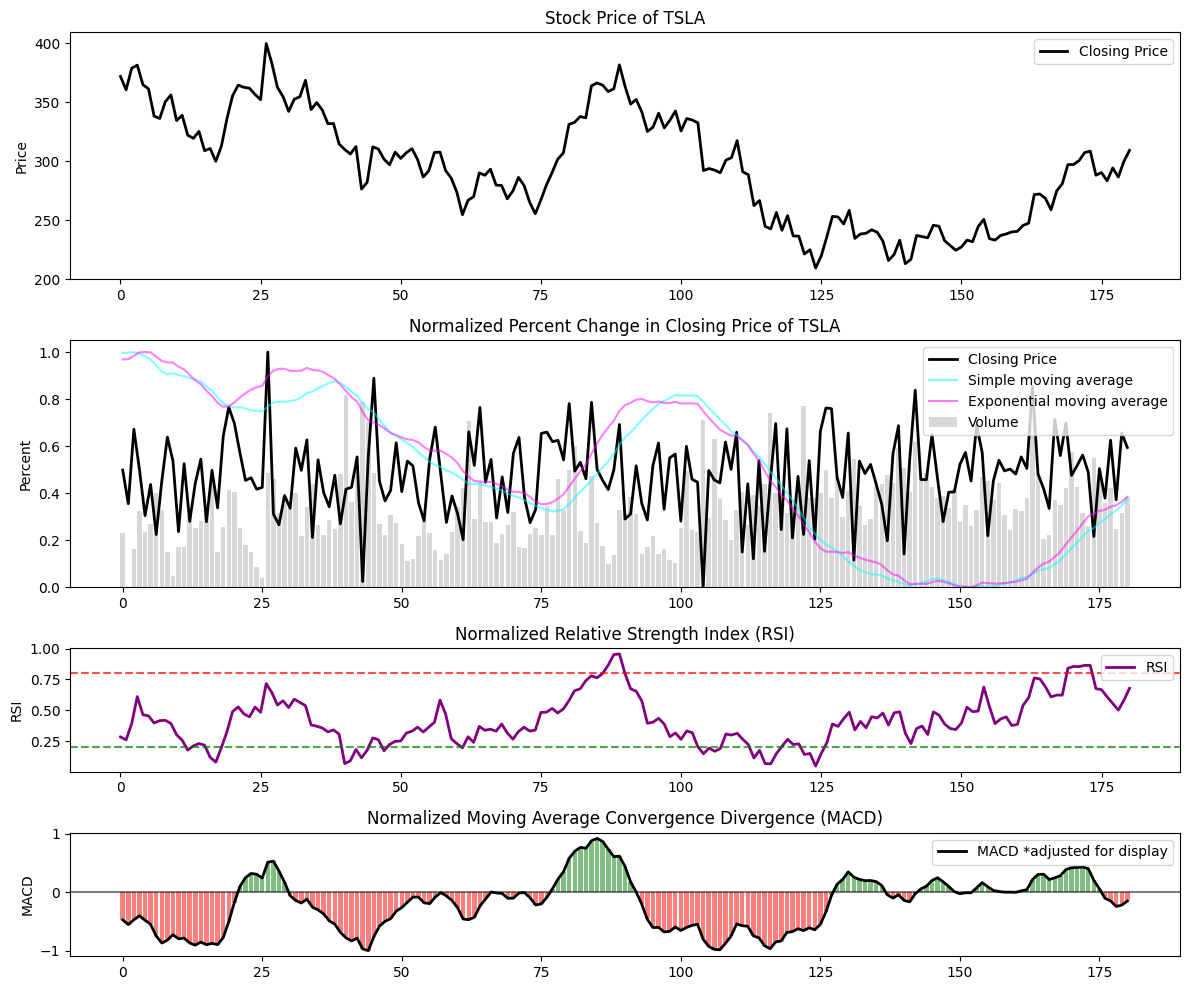

In [14]:
fig, axs = plt.subplots(4, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 2, 1, 1]})

# Plot stock price
axs[0].plot(plotting_data.index, plotting_data['close'], label="Closing Price", color='black', linewidth=2)
axs[0].set_title(f"Stock Price of {ticker}")
axs[0].set_ylabel("Price")
axs[0].legend(loc="upper right")

# Plot percent change with volume
axs[1].bar(plotting_data.index, plotting_data['volume'], label=f"Volume", color='grey', alpha=0.3)
axs[1].plot(plotting_data.index, plotting_data['percent_close'], label="Closing Price", color='black', linewidth=2)
axs[1].plot(plotting_data.index, plotting_data['sma'], label="Simple moving average", color='cyan', alpha=0.5)
axs[1].plot(plotting_data.index, plotting_data['ema'], label="Exponential moving average", color='magenta', alpha=0.5)
axs[1].set_title(f"Normalized Percent Change in Closing Price of {ticker}")
axs[1].set_ylabel("Percent")
axs[1].legend(loc="upper right")

# Plot RSI
axs[2].plot(plotting_data.index, plotting_data['rsi'], label="RSI", color='purple', linewidth=2)
axs[2].axhline(0.8, linestyle='dashed', color='red', alpha=0.7)
axs[2].axhline(0.2, linestyle='dashed', color='green', alpha=0.7)
axs[2].set_title("Normalized Relative Strength Index (RSI)")
axs[2].set_ylabel("RSI")
axs[2].legend(loc="upper right")

# Plot MACD
axs[3].plot(plotting_data.index, 2*(plotting_data['macd']-0.5), label="MACD *adjusted for display", color='black', linewidth=2)
axs[3].bar(plotting_data.index, 2*(plotting_data['macd']-0.5), 
           color=['green' if v >= 0 else 'red' for v in 2*(plotting_data['macd']-0.5)], 
           alpha=0.5)
axs[3].axhline(0, color='black', alpha=0.5)
axs[3].set_title("Normalized Moving Average Convergence Divergence (MACD)")
axs[3].set_ylabel("MACD")
axs[3].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Define Model

In [15]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, hidden_dim)
        
    def positional_encoding(self, seq_len, d_model):
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return tf.convert_to_tensor(pe, dtype=tf.float32)
        
    def call(self, x):
        return x + self.pos_encoding[:x.shape[1], :]

class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, sequence_length, hidden_dim, output_size, num_heads=4, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_heads = num_heads
        
        self.positional_encoding_layer = PositionalEncoding(sequence_length, hidden_dim)
        
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim // num_heads)
            for _ in range(num_layers)
        ]
        
        self.norm_layers_1 = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
            for _ in range(num_layers)
        ]
        
        self.norm_layers_2 = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6)
            for _ in range(num_layers)
        ]
        
        self.dropout_layers = [
            tf.keras.layers.Dropout(dropout_rate)
            for _ in range(num_layers)
        ]
        
        self.ffn_layers = [
            tf.keras.Sequential([
                tf.keras.layers.Dense(hidden_dim * 4, activation="relu"),
                tf.keras.layers.Dense(hidden_dim)
            ])
            for _ in range(num_layers)
        ]
        
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(hidden_dim // 2, activation="relu")
        self.dense2 = tf.keras.layers.Dense(output_size)
        self.price_change_output = tf.keras.layers.Dense(1, name="price_change_output")
        self.direction_output = tf.keras.layers.Dense(1, activation="sigmoid", name="direction_output")
    
    def call(self, x, training=None):
        # Apply Positional Encoding
        x = self.positional_encoding_layer(x)
        
        # Transformer Encoder Blocks
        for i in range(self.num_layers):
            # First sub-layer: Multi-head attention with residual connection and layer normalization
            attn_output = self.encoder_layers[i](x, x, attention_mask=None, training=training)
            x = self.norm_layers_1[i](x + attn_output)
            x = self.dropout_layers[i](x, training=training)
            
            # Second sub-layer: Feed forward network with residual connection and layer normalization
            ffn_output = self.ffn_layers[i](x)
            x = self.norm_layers_2[i](x + ffn_output)
            x = self.dropout_layers[i](x, training=training)
        
        # Reduce sequence dimension using Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Fully Connected Layers
        x = self.dense1(x)
        
        # Output layers for both price change and direction prediction
        price_change_pred = self.price_change_output(x)
        direction_pred = self.direction_output(x)
        
        return {"price_change_output": price_change_pred, "direction_output": direction_pred}

### Train Model

In [16]:
num_layers = 4
sequence_length = prev_days
hidden_dim = num_features
output_size = num_targets
num_heads = 4
dropout_rate = 0.1


# Initialize Transformer model
model = TransformerModel(num_layers, sequence_length, hidden_dim, output_size, num_heads, dropout_rate)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={
        "price_change_output": tf.keras.losses.MeanSquaredError(),
        "direction_output": tf.keras.losses.BinaryCrossentropy()
    },
    loss_weights={
        "price_change_output": 0.2,
        "direction_output": 0.8
    },
    metrics={
        "price_change_output": ["mae"],
        "direction_output": ["accuracy"]
    }
)

# Train the model
history = model.fit(
    x=train_x,
    y={"price_change_output": train_y[:, 0], "direction_output": train_y[:, 1]},  # Separate outputs
    epochs=50,
    batch_size=64,
    validation_data=(test_x, {"price_change_output": test_y[:, 0], "direction_output": test_y[:, 1]})
)

2025-02-27 23:53:26.379596: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-27 23:53:26.379916: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-27 23:53:26.379929: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-27 23:53:26.379953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 23:53:26.379970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-02-27 23:53:35.556573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 712ms/step - direction_output_accuracy: 0.5130 - direction_output_loss: 0.7878 - loss: 0.6740 - price_change_output_loss: 0.2187 - price_change_output_mae: 0.3704 - val_direction_output_accuracy: 0.6040 - val_direction_output_loss: 0.6763 - val_loss: 0.5551 - val_price_change_output_loss: 0.0699 - val_price_change_output_mae: 0.2316
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 515ms/step - direction_output_accuracy: 0.5271 - direction_output_loss: 0.7068 - loss: 0.5836 - price_change_output_loss: 0.0908 - price_change_output_mae: 0.2404 - val_direction_output_accuracy: 0.6040 - val_direction_output_loss: 0.6764 - val_loss: 0.5531 - val_price_change_output_loss: 0.0601 - val_price_change_output_mae: 0.2144
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 576ms/step - direction_output_accuracy: 0.5262 - direction_output_loss: 0.7054 - loss: 0.5793 - price_change_output_loss: 0.0751 - price_change_output_mae: 0.2160 - val_direction_output_accuracy: 0.6040 - val_direct

### Plot Performance

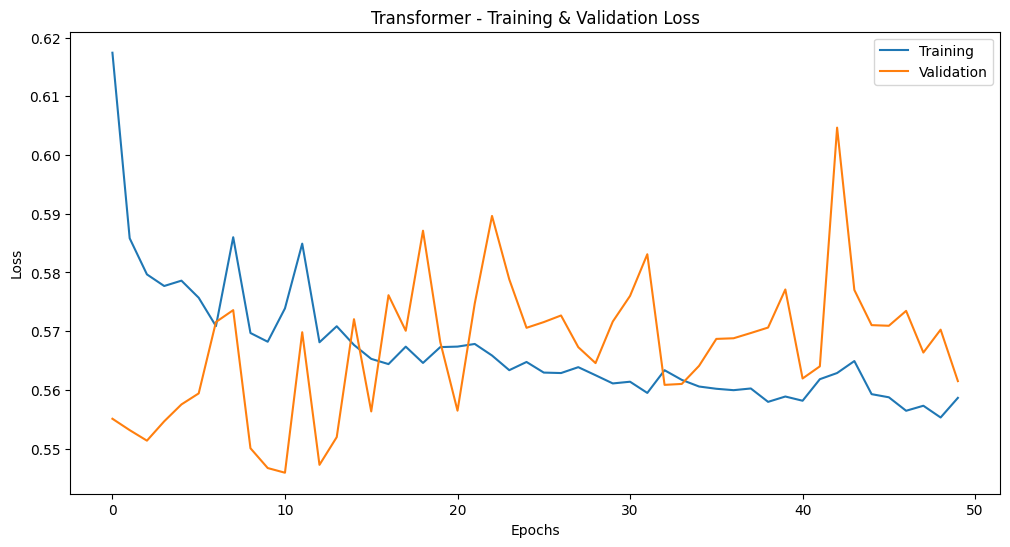

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(loss))

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer - Training & Validation Loss')
plt.legend(loc='upper right')
plt.show()

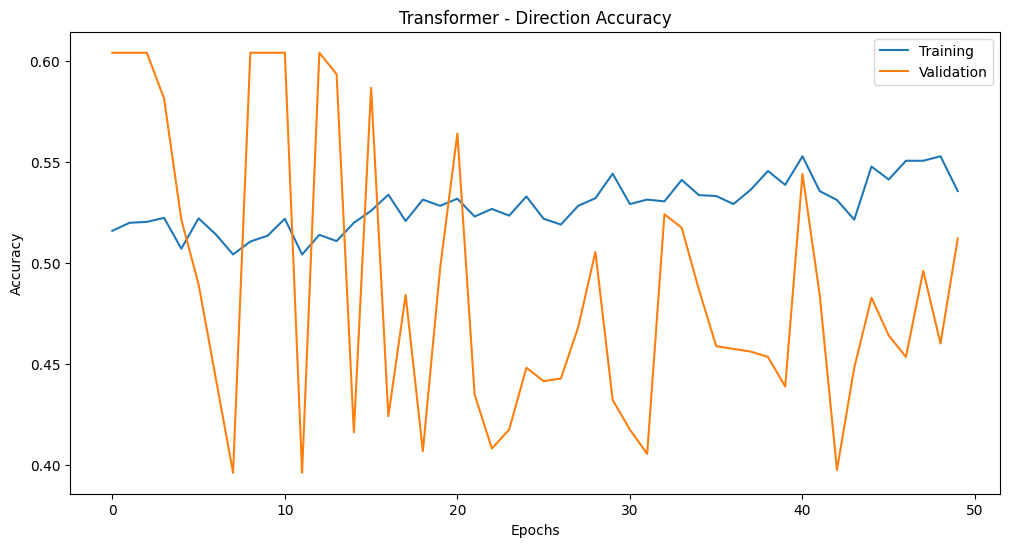

In [18]:
direction_accuracy = history.history['direction_output_accuracy']
val_direction_accuracy = history.history['val_direction_output_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(direction_accuracy, label="Training")
plt.plot(val_direction_accuracy, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transformer - Direction Accuracy")
plt.legend(loc='upper right')
plt.show()

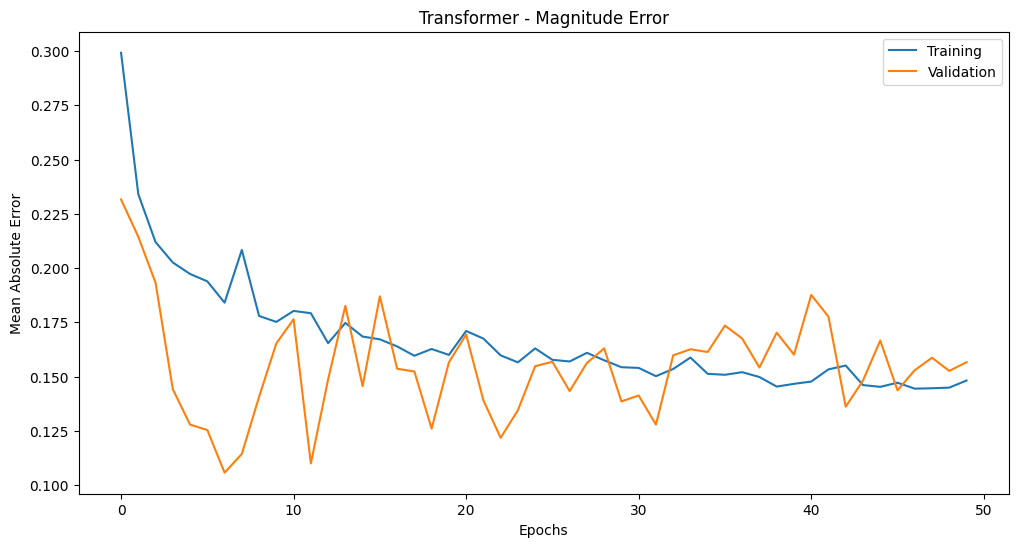

In [19]:
price_change_output_mae = history.history['price_change_output_mae']
val_price_change_output_mae = history.history['val_price_change_output_mae']

plt.figure(figsize=(12, 6))
plt.plot(price_change_output_mae, label="Training")
plt.plot(val_price_change_output_mae, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Transformer - Magnitude Error")
plt.legend(loc='upper right')
plt.show()

In [20]:
train_pred = model.predict(train_x)
train_pred_magnitude= train_pred['price_change_output']
train_pred_direction = (train_pred['direction_output'] > 0.5).astype(int)
train_actual_magnitude = train_y[:, 0]
train_actual_direction = train_y[:, 1]

test_pred = model.predict(test_x)
test_pred_magnitude = test_pred['price_change_output']
test_pred_direction = (test_pred['direction_output'] > 0.5).astype(int)
test_actual_magnitude = test_y[:, 0]
test_actual_direction = test_y[:, 1]

142/142 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


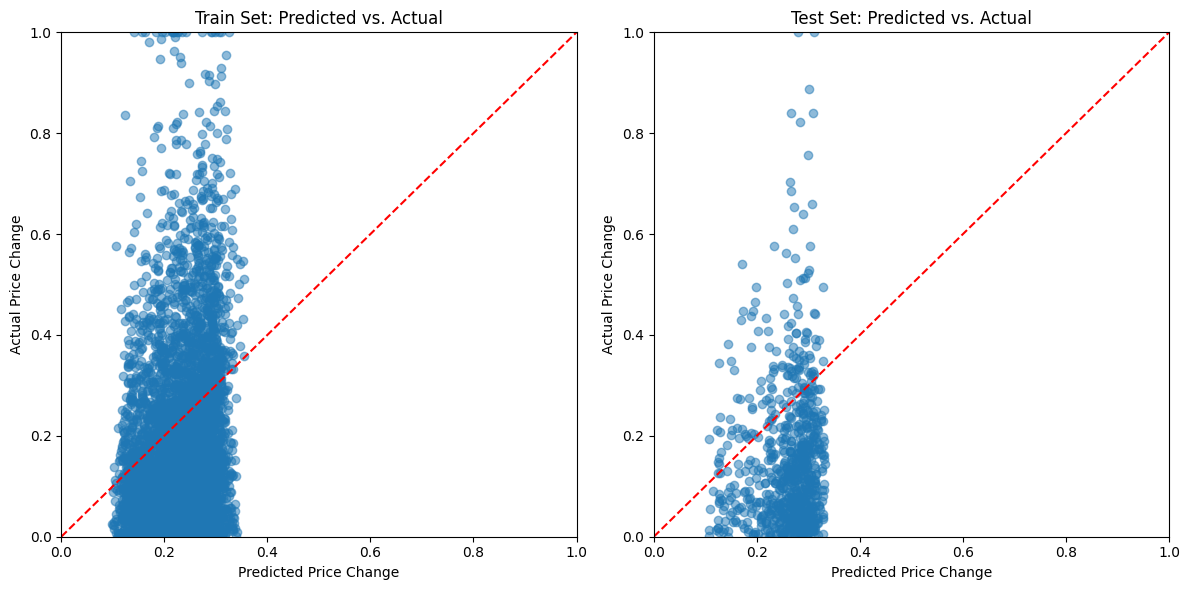

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(train_pred_magnitude, train_actual_magnitude, alpha=0.5, label="Train Data")
axs[0].set_xlabel("Predicted Price Change")
axs[0].set_ylabel("Actual Price Change")
axs[0].set_title("Train Set: Predicted vs. Actual")
axs[0].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])

axs[1].scatter(test_pred_magnitude, test_actual_magnitude, alpha=0.5, label="Test Data")
axs[1].set_xlabel("Predicted Price Change")
axs[1].set_ylabel("Actual Price Change")
axs[1].set_title("Test Set: Predicted vs. Actual")
axs[1].axline((0, 0), slope=1, color="red", linestyle="dashed")  # Reference line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])

plt.tight_layout()
plt.show()

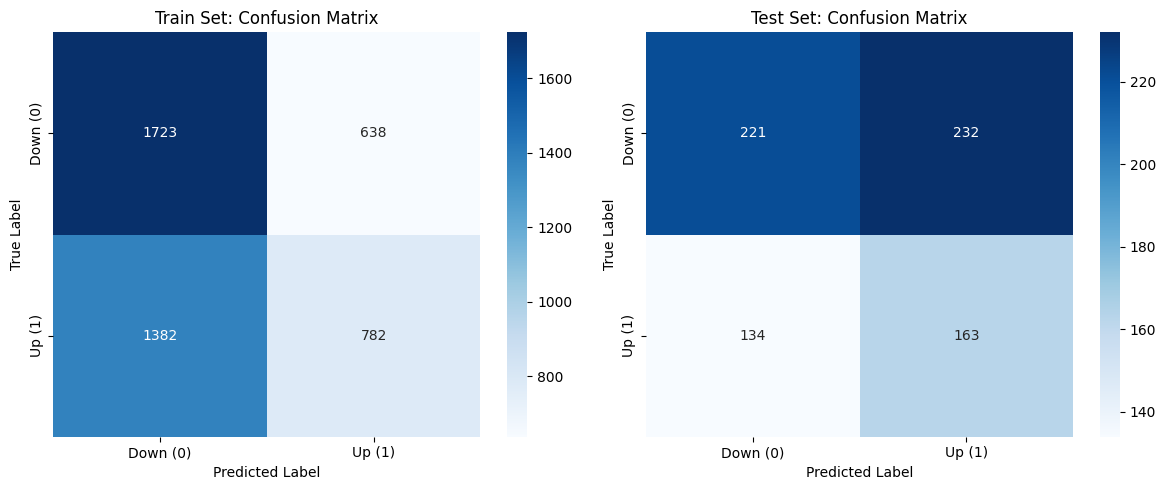

In [22]:
train_cm = confusion_matrix(train_actual_direction, train_pred_direction)
test_cm = confusion_matrix(test_actual_direction, test_pred_direction)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[0])
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_title("Train Set: Confusion Matrix")

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down (0)", "Up (1)"], yticklabels=["Down (0)", "Up (1)"], ax=axes[1])
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Test Set: Confusion Matrix")

plt.tight_layout()
plt.show()

In [23]:
train_report = classification_report(train_actual_direction, train_pred_direction, target_names=["Down (0)", "Up (1)"])
test_report = classification_report(test_actual_direction, test_pred_direction, target_names=["Down (0)", "Up (1)"])

print("Train Classification Report:\n", train_report)
print("\nTest Classification Report:\n", test_report)

Train Classification Report:
               precision    recall  f1-score   support

    Down (0)       0.55      0.73      0.63      2361
      Up (1)       0.55      0.36      0.44      2164

    accuracy                           0.55      4525
   macro avg       0.55      0.55      0.53      4525
weighted avg       0.55      0.55      0.54      4525


Test Classification Report:
               precision    recall  f1-score   support

    Down (0)       0.62      0.49      0.55       453
      Up (1)       0.41      0.55      0.47       297

    accuracy                           0.51       750
   macro avg       0.52      0.52      0.51       750
weighted avg       0.54      0.51      0.52       750



### Calculate Stock Price Predictions

In [24]:
train_pred_percent = train_pred_magnitude * (2 * train_pred_direction - 1)
test_pred_percent = test_pred_magnitude * (2 * test_pred_direction - 1)

In [25]:
train_data['predicted_percent_close'] = np.nan
for ticker in np.unique(train_tickers):
    stock_indices = np.where(train_tickers == ticker)[0]
    train_data.loc[train_data['stock_name'] == ticker, 'predicted_percent_close'] = train_pred_percent[stock_indices]

In [26]:
test_data['predicted_percent_close'] = np.nan
for ticker in np.unique(test_tickers):
    stock_indices = np.where(test_tickers == ticker)[0]
    test_data.loc[test_data['stock_name'] == ticker, 'predicted_percent_close'] = test_pred_percent[stock_indices]

In [27]:
train_data['predicted_close'] = np.nan

for ticker in np.unique(train_tickers):
    scaler = scalers[ticker]
    
    stock_rows = train_data['stock_name'] == ticker
    stock_predicted_percent = train_data.loc[stock_rows, 'predicted_percent_close'].values.reshape(-1, 1)

    if len(stock_predicted_percent) > 0:
        # Create dummy feature set for inverse transformation
        dummy_features = np.zeros((len(stock_predicted_percent), len(feature_cols)))  
        
        # Denormalize and compute predicted close price
        denormalized_predicted_percent = scaler.inverse_transform(
            np.column_stack([dummy_features, stock_predicted_percent])
        )[:, -1]

        # Shift the actual close price by one day (previous close)
        prev_close_price = train_data.loc[stock_rows, 'close'].shift(1)

        # Compute predicted close price
        train_data.loc[stock_rows, 'predicted_close'] = prev_close_price * (1 + denormalized_predicted_percent / 100)

In [28]:
test_data['predicted_close'] = np.nan

for ticker in np.unique(test_tickers):
    scaler = scalers[ticker]
    
    stock_rows = test_data['stock_name'] == ticker
    stock_predicted_percent = test_data.loc[stock_rows, 'predicted_percent_close'].values.reshape(-1, 1)

    if len(stock_predicted_percent) > 0:
        # Create dummy feature set for inverse transformation
        dummy_features = np.zeros((len(stock_predicted_percent), len(feature_cols)))  
        
        # Denormalize and compute predicted close price
        denormalized_predicted_percent = scaler.inverse_transform(
            np.column_stack([dummy_features, stock_predicted_percent])
        )[:, -1]

        # Shift the actual close price by one day (previous close)
        prev_close_price = test_data.loc[stock_rows, 'close'].shift(1)

        # Compute predicted close price
        test_data.loc[stock_rows, 'predicted_close'] = prev_close_price * (1 + denormalized_predicted_percent / 100)

In [29]:
train_data['forecast'] = np.nan

for ticker in np.unique(train_tickers):
    stock_rows = train_data['stock_name'] == ticker
    stock_df = train_data.loc[stock_rows].copy()

    # Get the first actual close price (the starting reference point)
    first_actual_close = stock_df['close'].iloc[0]

    # Initialize an array to store accumulated predictions
    accumulated_prices = [first_actual_close]

    # Compute accumulated forecast
    for i in range(1, len(stock_df)):
        predicted_change = stock_df['predicted_close'].iloc[i] - stock_df['close'].iloc[i-1]
        new_forecast_price = accumulated_prices[-1] + predicted_change
        accumulated_prices.append(new_forecast_price)

    # Store results back in the DataFrame
    train_data.loc[stock_rows, 'forecast'] = accumulated_prices

In [30]:
test_data['forecast'] = np.nan

for ticker in np.unique(test_tickers):
    stock_rows = test_data['stock_name'] == ticker
    stock_df = test_data.loc[stock_rows].copy()

    # Get the first actual close price (the starting reference point)
    first_actual_close = stock_df['close'].iloc[0]

    # Initialize an array to store accumulated predictions
    accumulated_prices = [first_actual_close]

    # Compute accumulated forecast
    for i in range(1, len(stock_df)):
        predicted_change = stock_df['predicted_close'].iloc[i] - stock_df['close'].iloc[i-1]
        new_forecast_price = accumulated_prices[-1] + predicted_change
        accumulated_prices.append(new_forecast_price)

    # Store results back in the DataFrame
    test_data.loc[stock_rows, 'forecast'] = accumulated_prices

### Plot Predictions

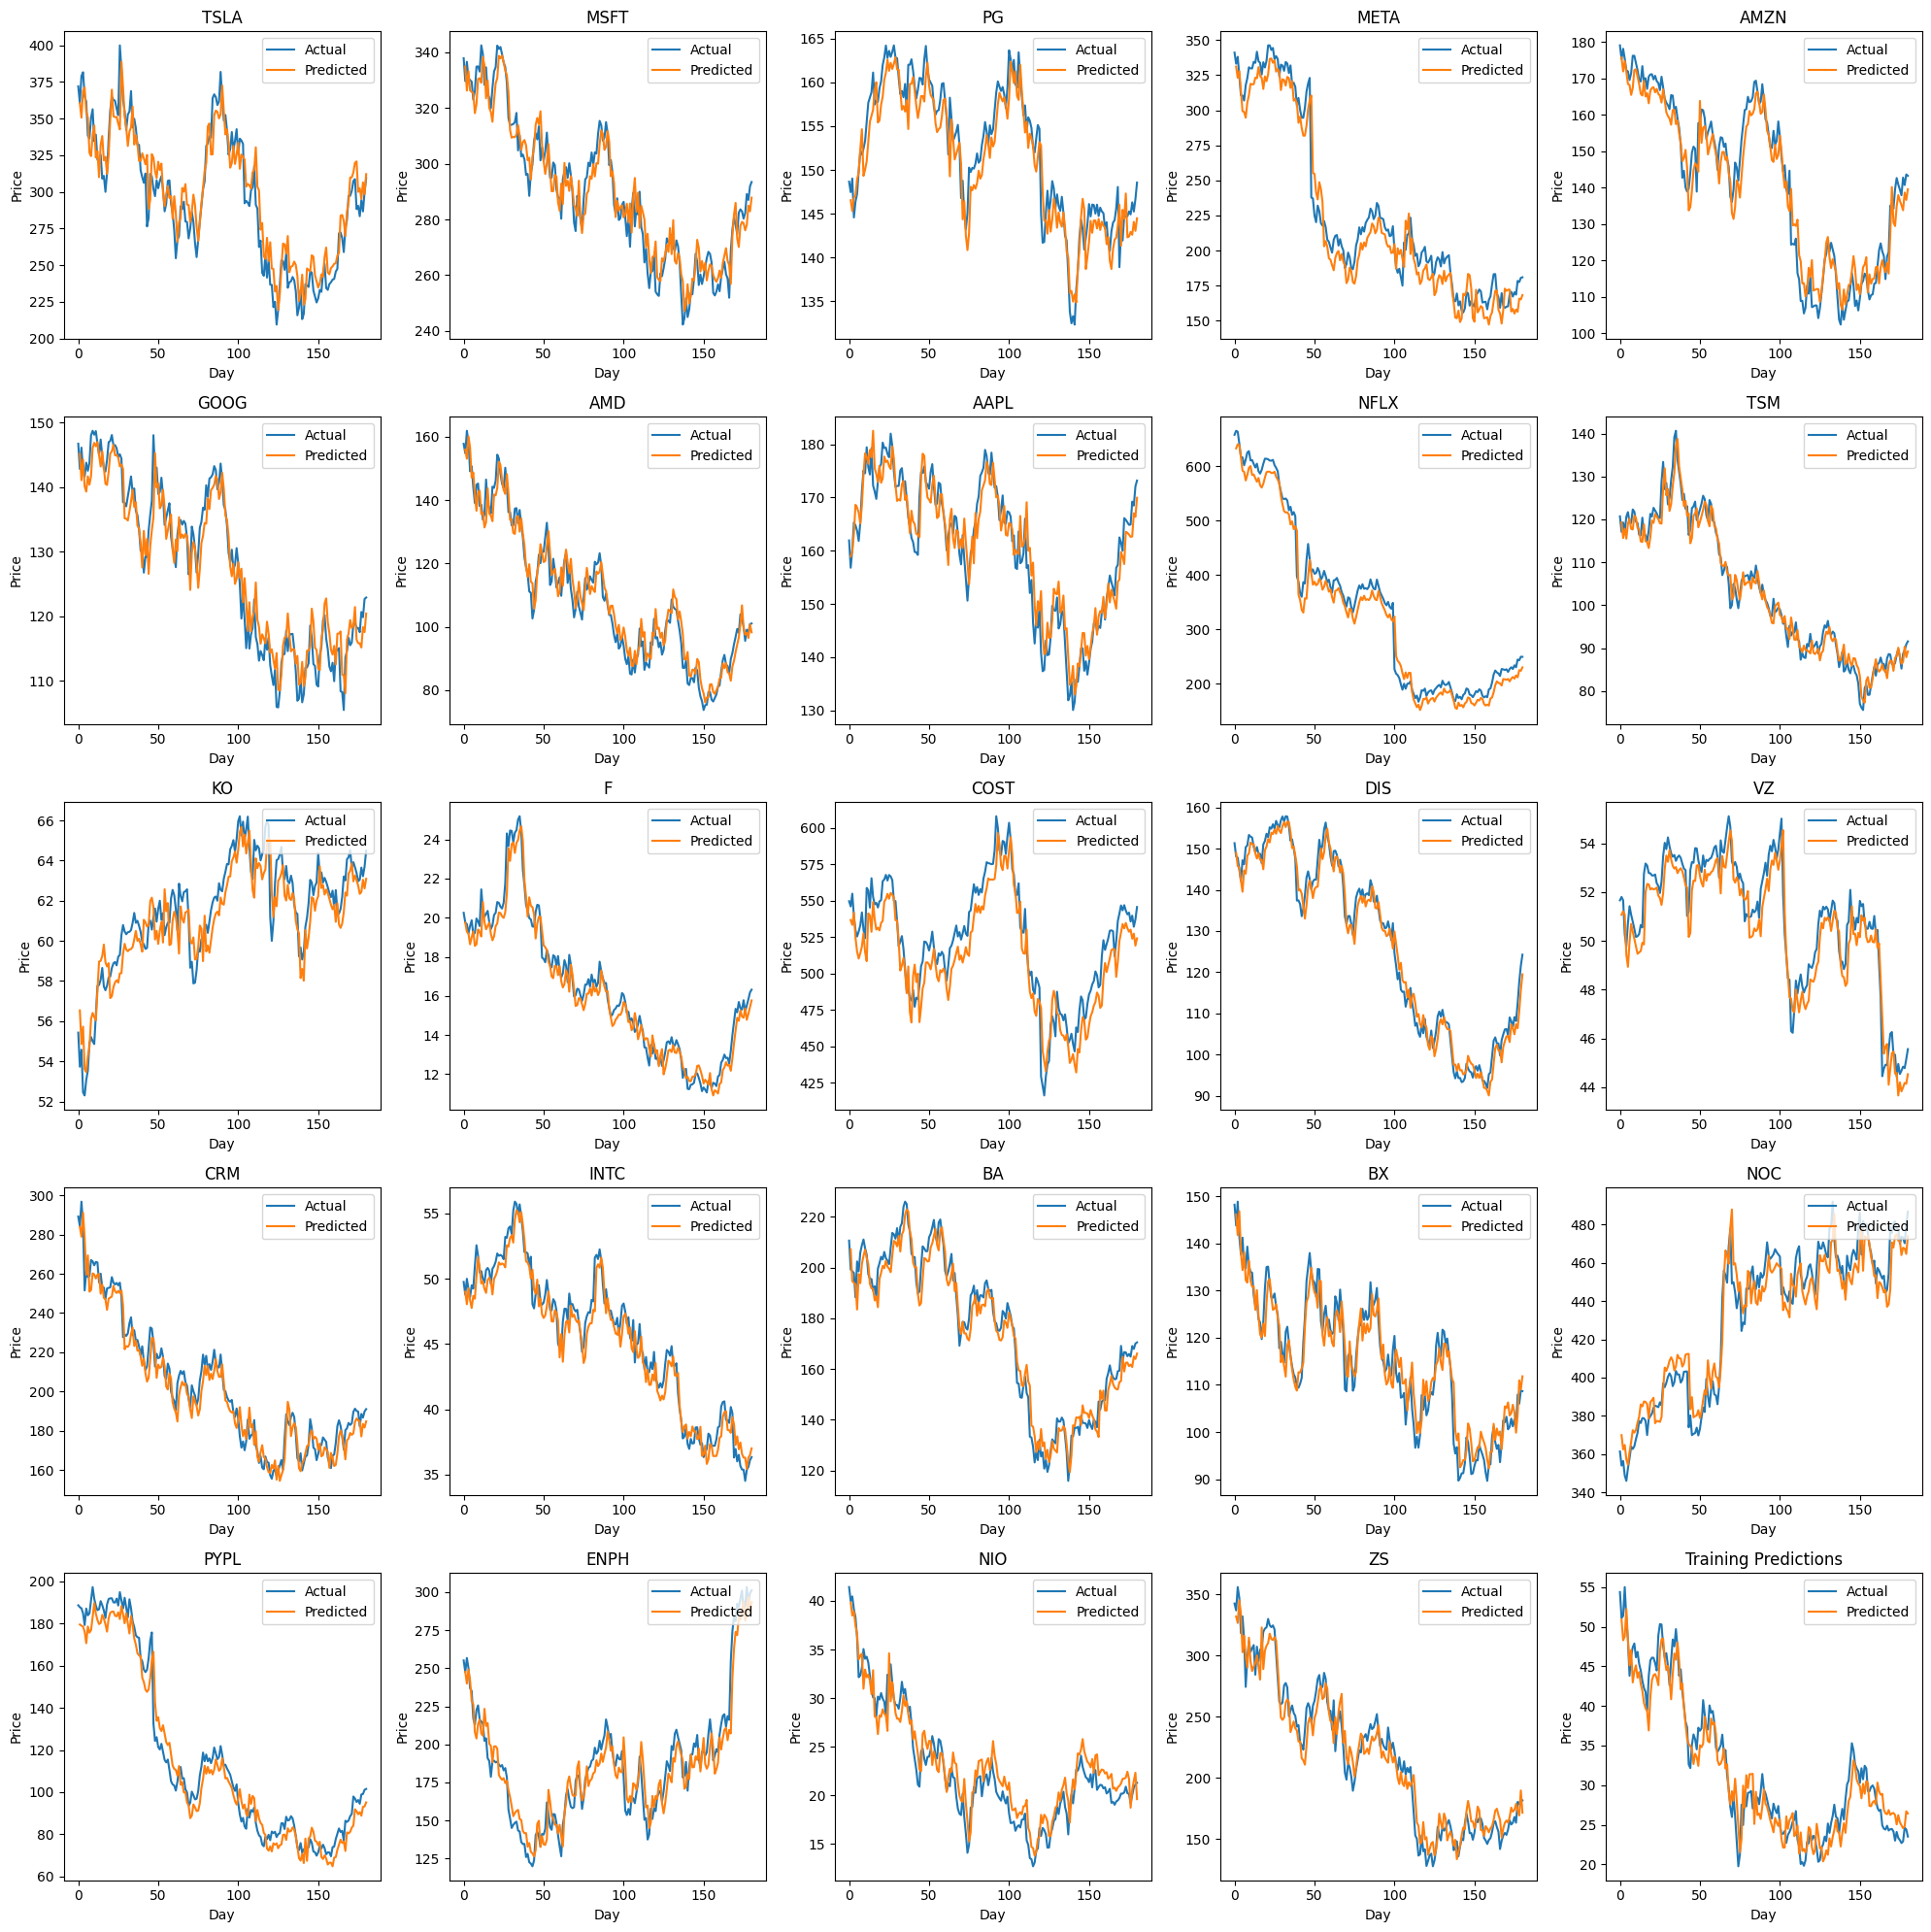

In [31]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

for i, stock in enumerate(tickers):

    stock_df = train_data[train_data['stock_name'] == stock]
    stock_df.reset_index(inplace=True)

    ax = axes[i]
    ax.plot(stock_df.index, stock_df['close'], label='Actual')
    ax.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.title('Training Predictions')
plt.tight_layout()
plt.show()

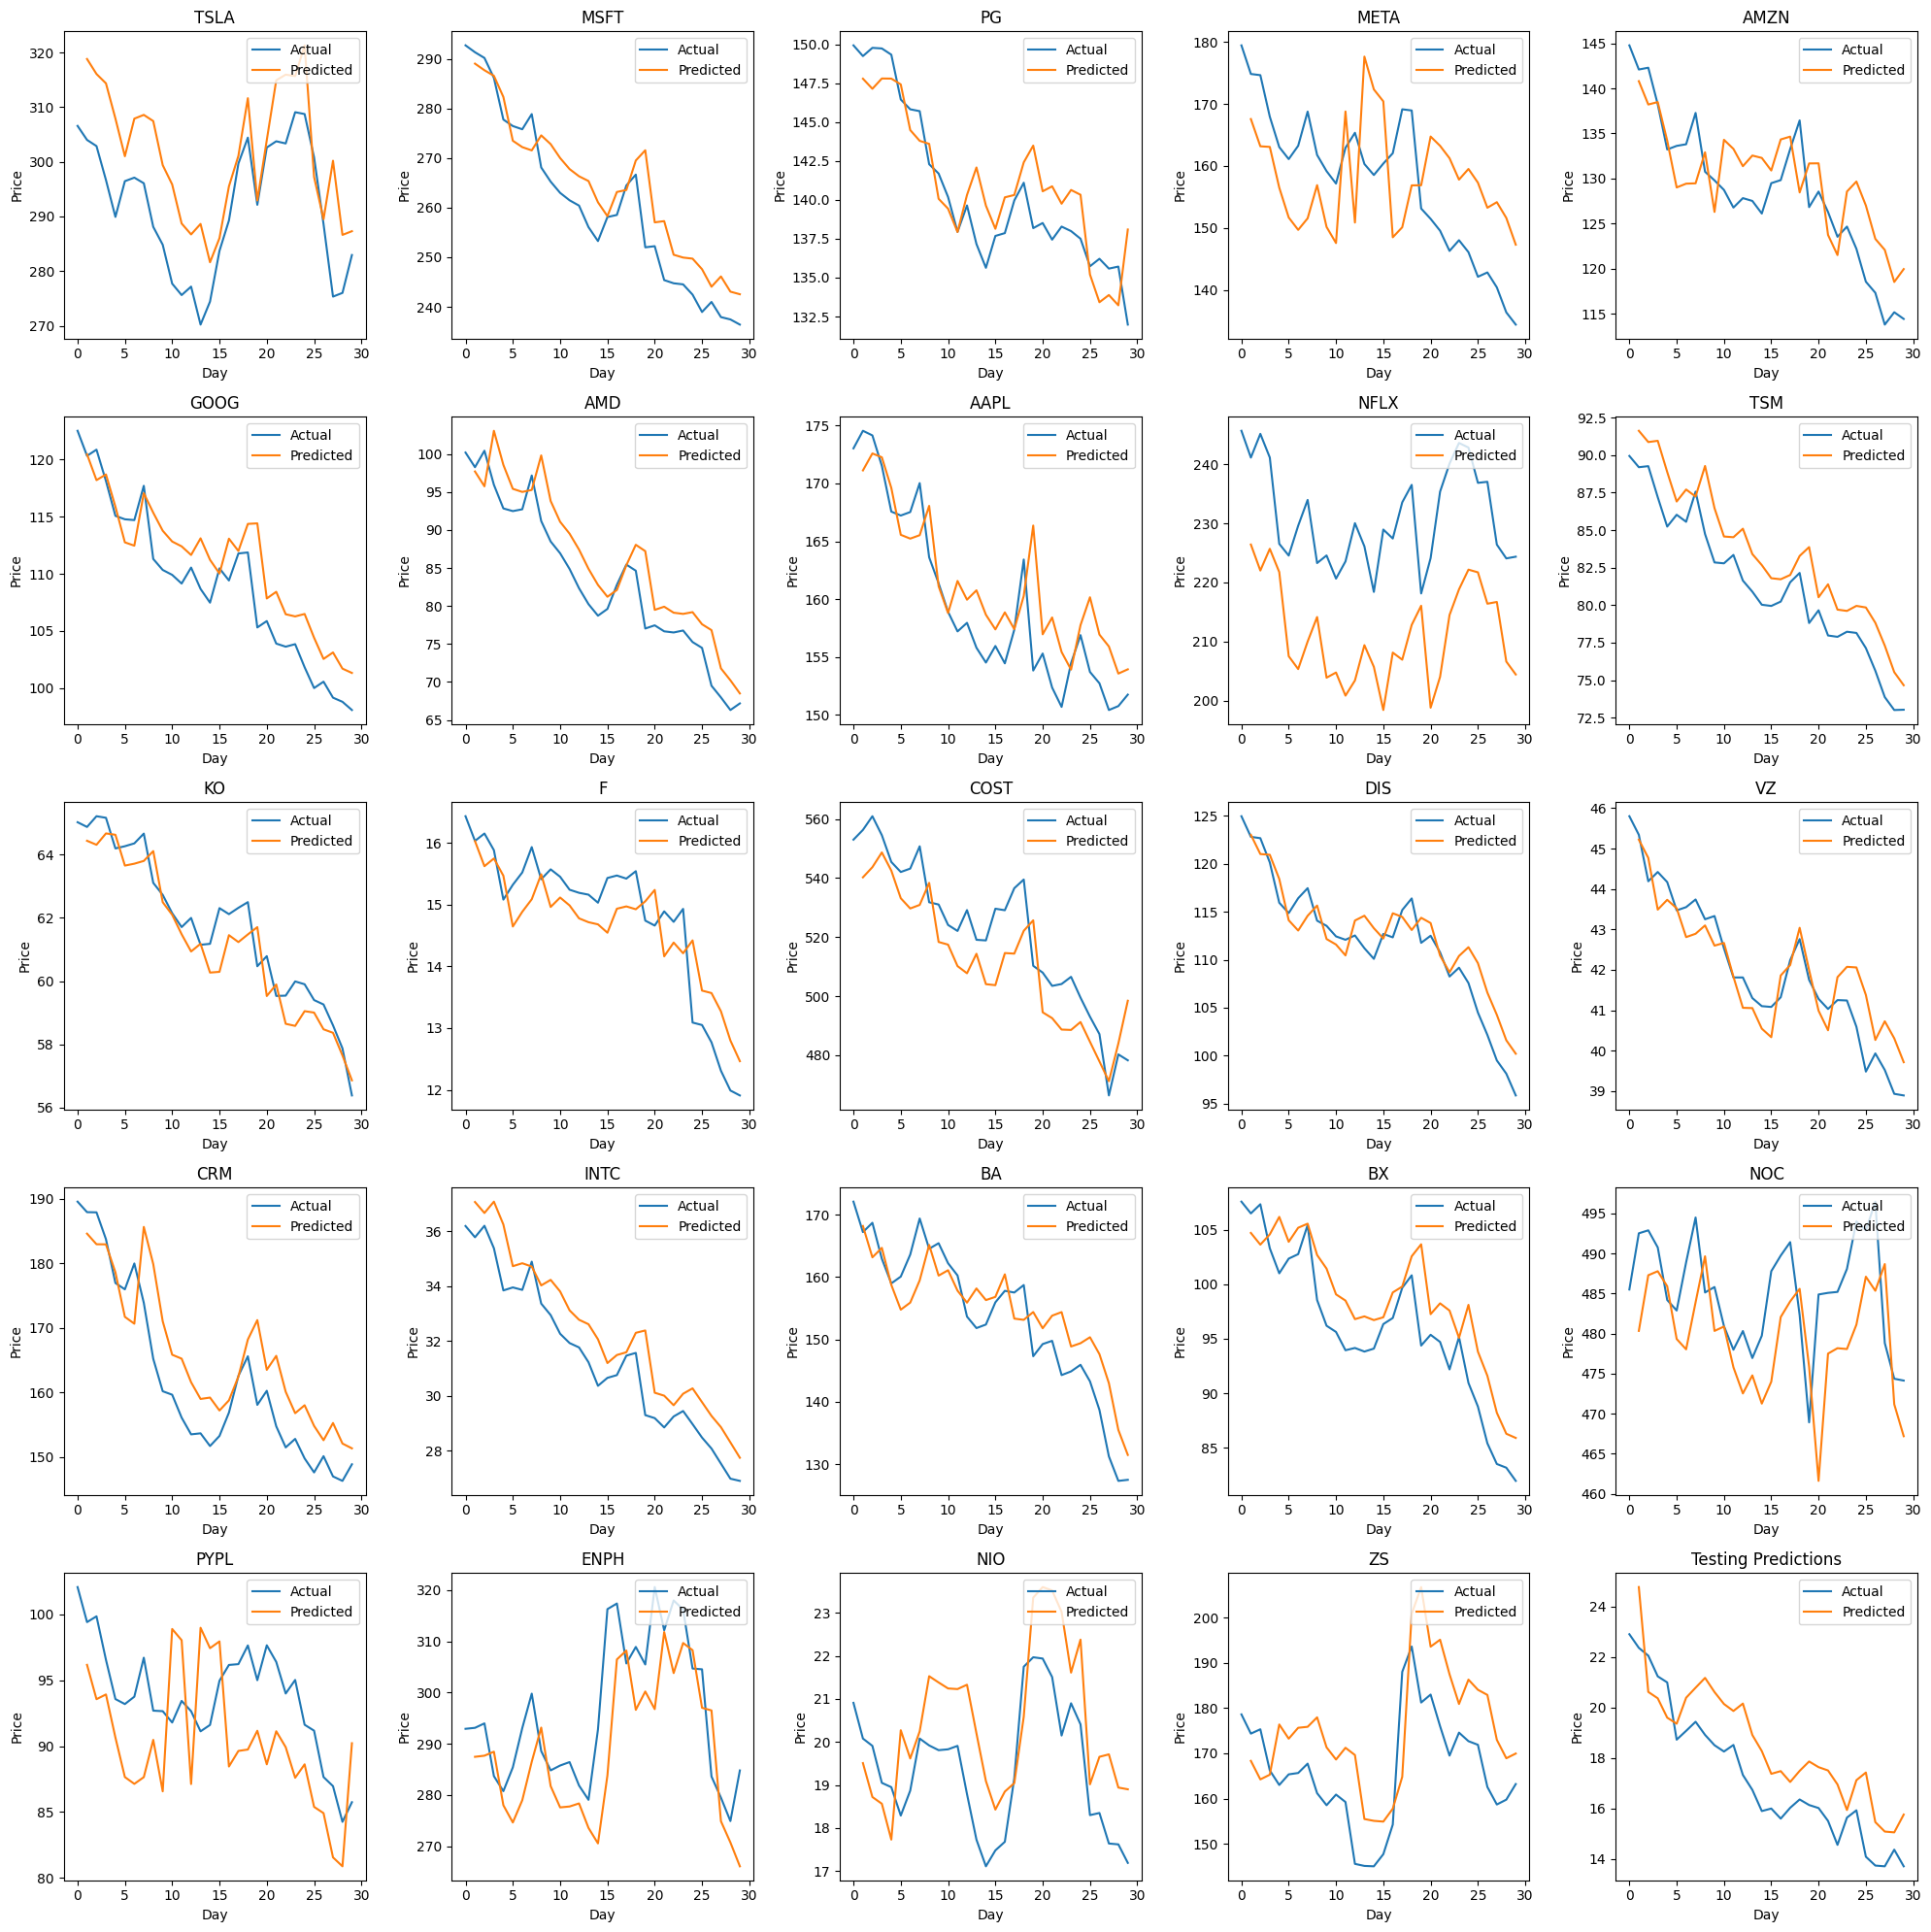

In [32]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

for i, stock in enumerate(tickers):

    stock_df = test_data[test_data['stock_name'] == stock]
    stock_df.reset_index(inplace=True)

    ax = axes[i]
    ax.plot(stock_df.index, stock_df['close'], label='Actual')
    ax.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.title('Testing Predictions')
plt.tight_layout()
plt.show()

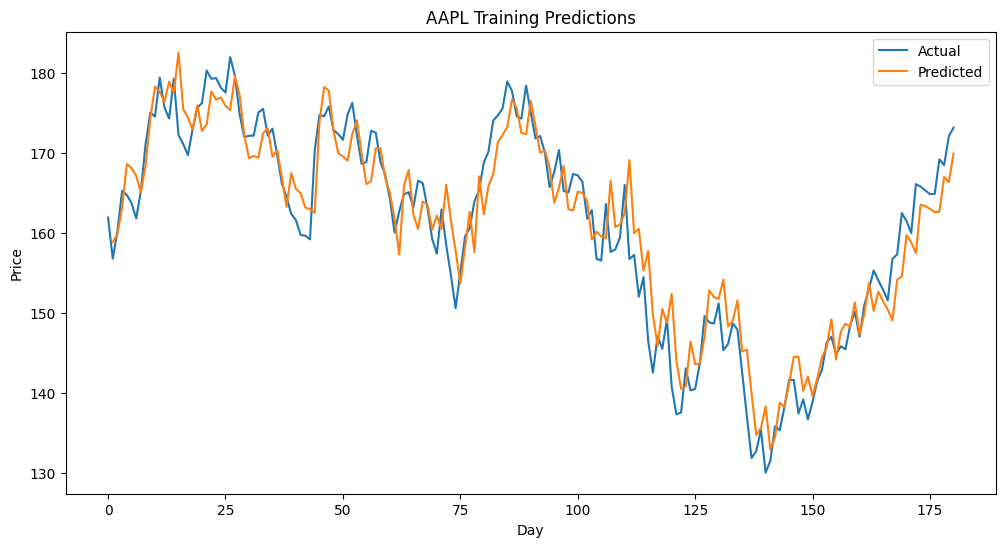

In [39]:
stock = "AAPL"

stock_df = train_data[train_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(stock_df.index, stock_df['close'], label='Actual')
plt.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Training Predictions')
plt.legend(loc='upper right')

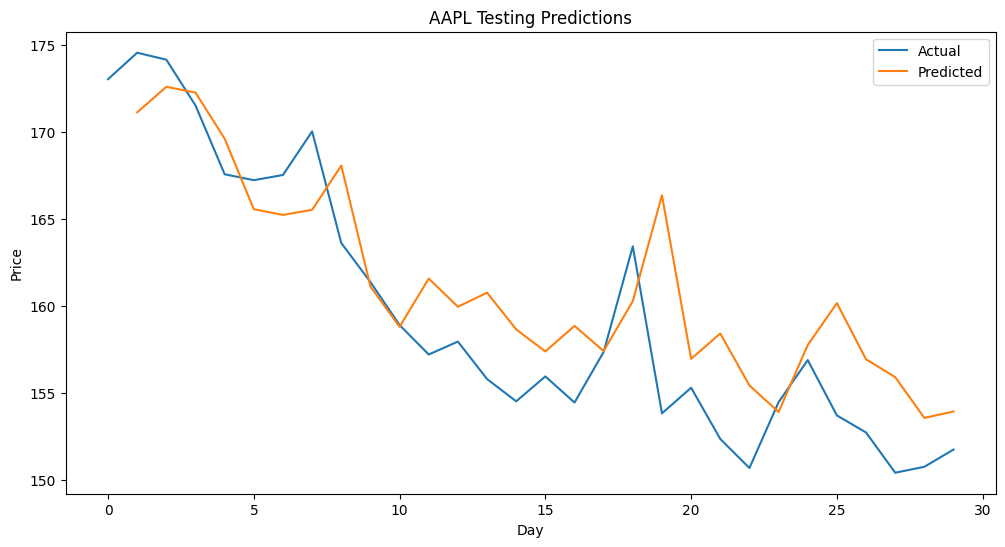

In [40]:
stock = "AAPL"

stock_df = test_data[test_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(i, figsize=(12, 6))
plt.plot(stock_df.index, stock_df['close'], label='Actual')
plt.plot(stock_df.index, stock_df['predicted_close'], label='Predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Testing Predictions')
plt.legend(loc='upper right')

plt.show()

### Plot Forecast

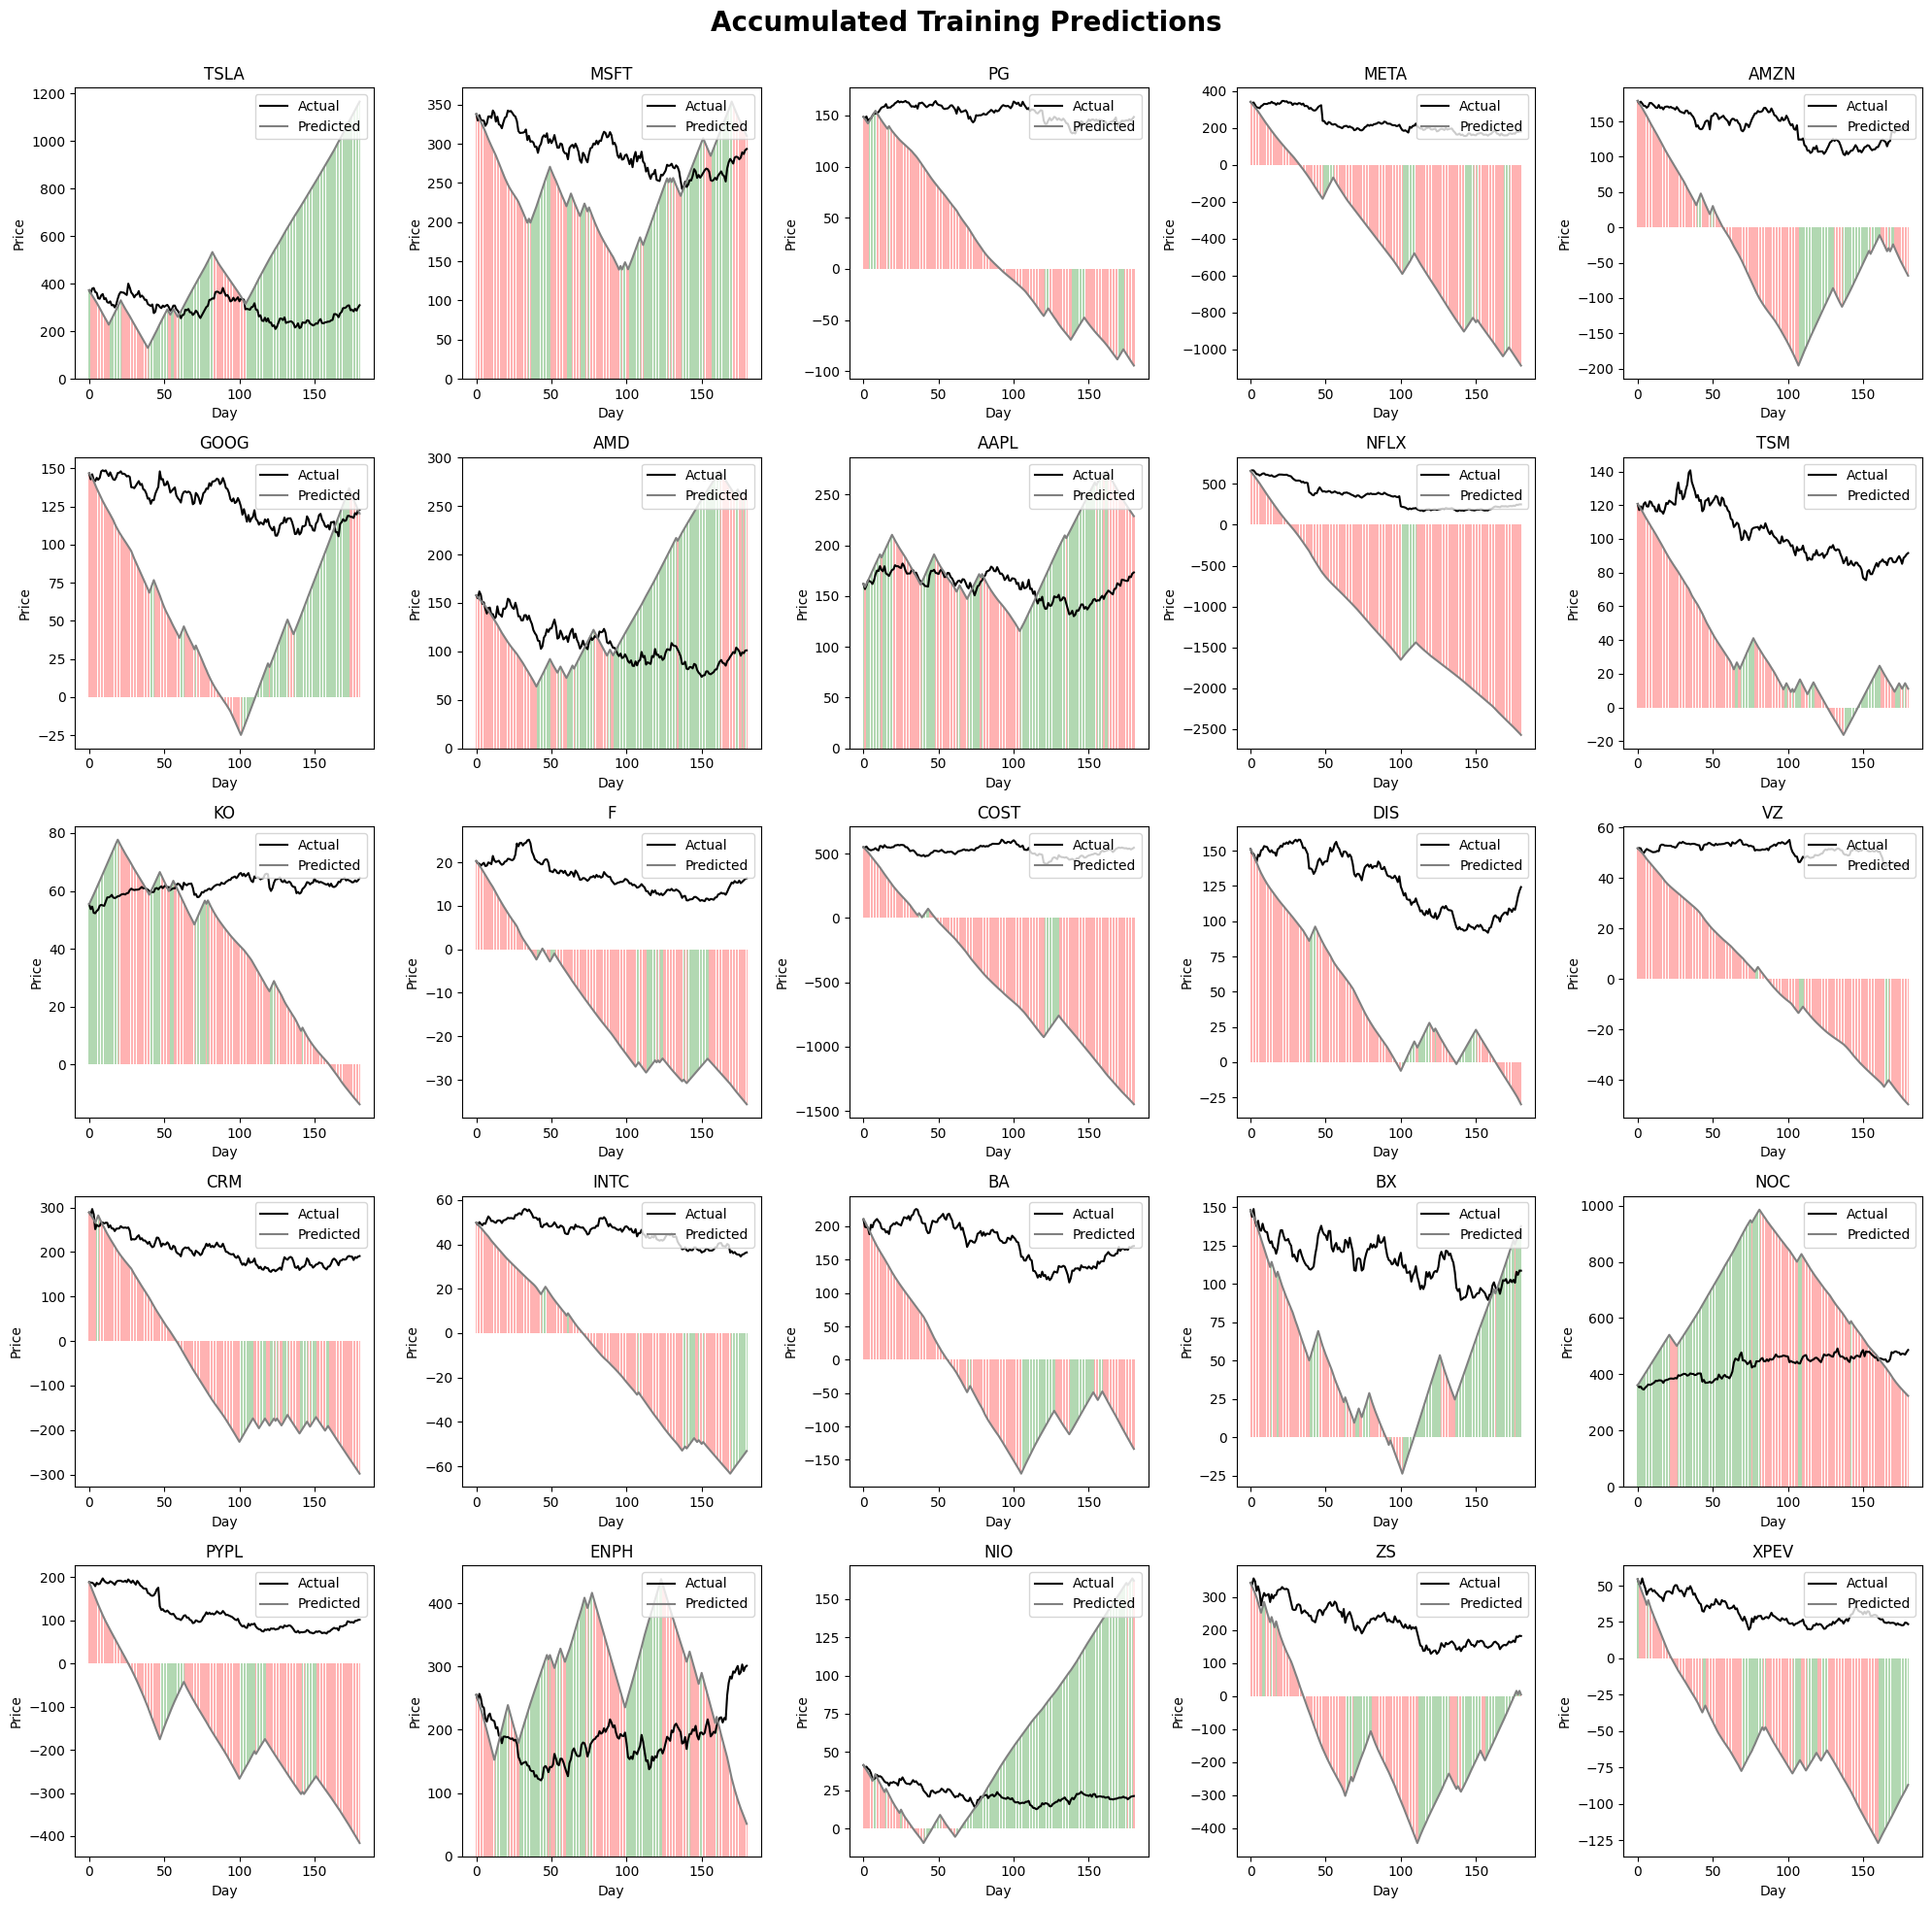

In [35]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

fig.suptitle('Accumulated Training Predictions', fontsize=20, fontweight='bold')

for i, stock in enumerate(tickers):

    stock_df = train_data[train_data['stock_name'] == stock].copy()
    stock_df.reset_index(inplace=True)
  
    ax = axes[i]
    
    colors = ['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']]
    
    ax.bar(stock_df.index, stock_df['forecast'], color=colors, alpha=0.3)
    ax.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
    ax.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

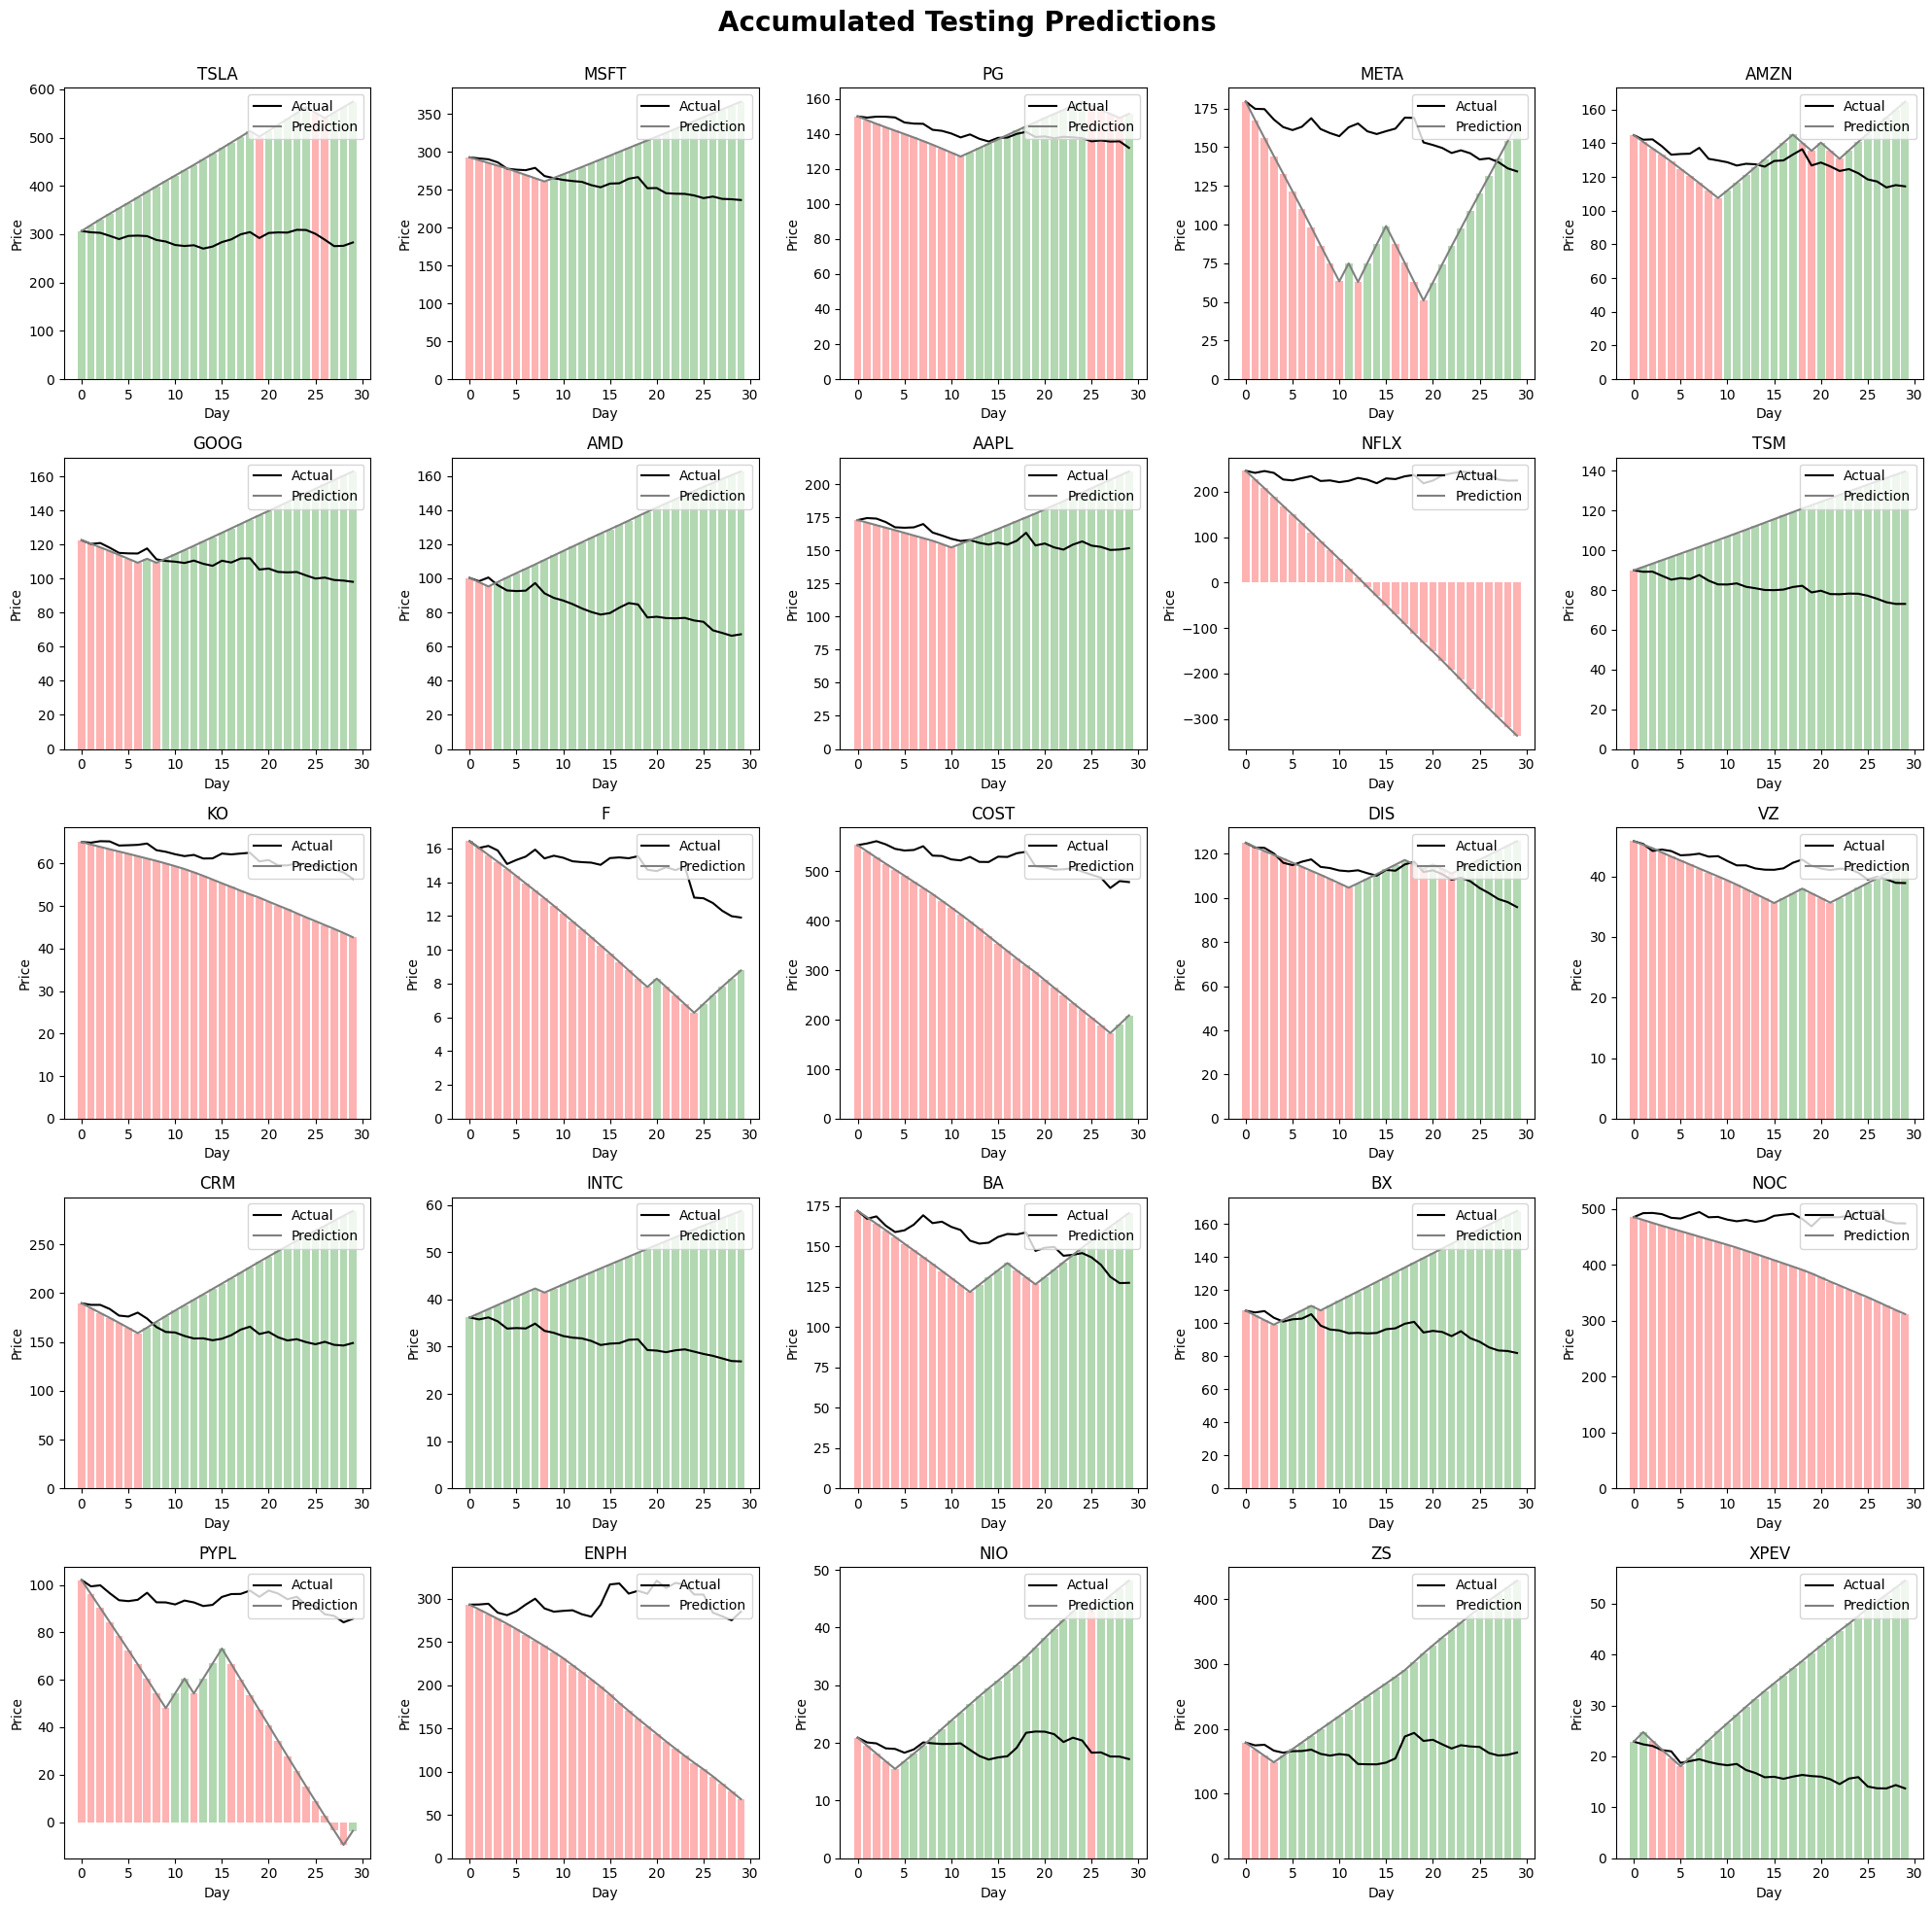

In [36]:
grid_size = (5, 5)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
axes = axes.flatten()

fig.suptitle('Accumulated Testing Predictions', fontsize=20, fontweight='bold')

for i, stock in enumerate(tickers):

    stock_df = test_data[test_data['stock_name'] == stock].copy()
    stock_df.reset_index(inplace=True)
  
    ax = axes[i]
    
    colors = ['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']]

    ax.bar(stock_df.index, stock_df['forecast'], color=colors, alpha=0.3)
    ax.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
    ax.plot(stock_df.index, stock_df['forecast'], label='Prediction', color='grey')
    ax.set_title(f'{stock}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Price')
    ax.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

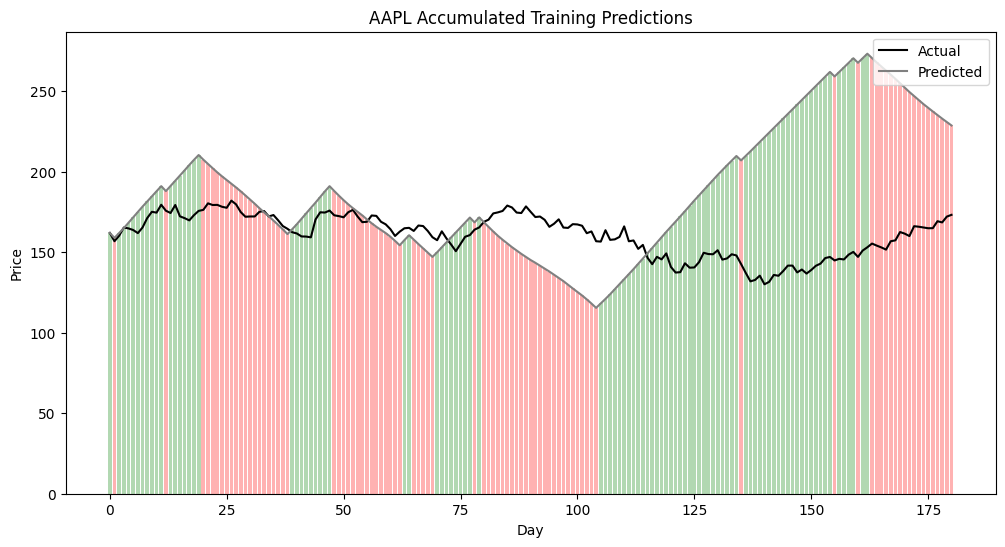

In [37]:
stock = "AAPL"

stock_df = train_data[train_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(stock_df.index, stock_df['forecast'], 
        color=['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']], 
        alpha=0.3)
plt.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
plt.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Accumulated Training Predictions')
plt.legend(loc='upper right')
plt.show()

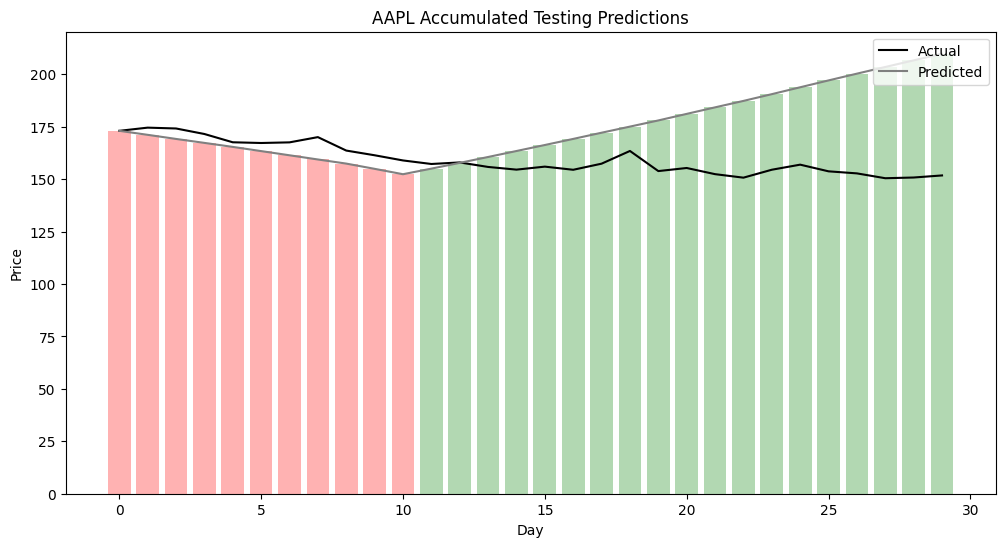

In [38]:
stock = "AAPL"

stock_df = test_data[test_data['stock_name'] == stock]
stock_df.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(stock_df.index, stock_df['forecast'], 
        color=['green' if v > 0 else 'red' for v in stock_df['predicted_percent_close']], 
        alpha=0.3)
plt.plot(stock_df.index, stock_df['close'], label='Actual', color='black')
plt.plot(stock_df.index, stock_df['forecast'], label='Predicted', color='grey')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'{stock} Accumulated Testing Predictions')
plt.legend(loc='upper right')
plt.show()